In [1]:
import pathlib

import torch
from easydict import EasyDict as edict
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from deep_svdd import get_mnist

sns.set_theme(style="whitegrid")
PROJECT_ROOT = pathlib.Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
print(f"Using data directory: {DATA_DIR}")


Using data directory: C:\Users\jspar\Desktop\SCHOOL\3-2\인공지능응용\Anomaly_Detection_Practice_Bundle_and_1_others\assignment\data


In [2]:
args = edict({
    "normal_class": 0,
    "batch_size": 256,
})

dataloader_train, dataloader_test = get_mnist(args, data_dir=str(DATA_DIR))
raw_test = datasets.MNIST(root=str(DATA_DIR), train=False, download=True)

print(f"Train batches: {len(dataloader_train)}")
print(f"Test batches: {len(dataloader_test)}")


Train batches: 24
Test batches: 40


In [3]:
sample_size = 3000
flat_samples = []
binary_labels = []
digit_labels = []
collected = 0
offset = 0

for batch_x, batch_y in dataloader_test:
    batch_size = batch_x.size(0)
    take = min(batch_size, sample_size - collected)
    if take <= 0:
        break
    flat_samples.append(batch_x[:take].view(take, -1))
    binary_labels.append(batch_y[:take])
    digit_labels.append(raw_test.targets[offset:offset + take])
    collected += take
    offset += take

X = torch.cat(flat_samples).numpy()
y_binary = torch.cat(binary_labels).numpy()
y_digits = torch.cat(digit_labels).numpy()

print(f"Collected samples: {X.shape[0]}")


Collected samples: 3000


In [4]:
pca = PCA(n_components=2, random_state=42)
pca_emb = pca.fit_transform(X)

perplexity = 35 if X.shape[0] > 1000 else 20
tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    init="pca",
    learning_rate="auto",
    random_state=42,
)
tsne_emb = tsne.fit_transform(X)

print("Explained variance ratio (PCA):", pca.explained_variance_ratio_)


Explained variance ratio (PCA): [0.12565136 0.07406066]


C:\Users\jspar\AppData\Local\Temp\ipykernel_65636\439970609.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")
C:\Users\jspar\AppData\Local\Temp\ipykernel_65636\439970609.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


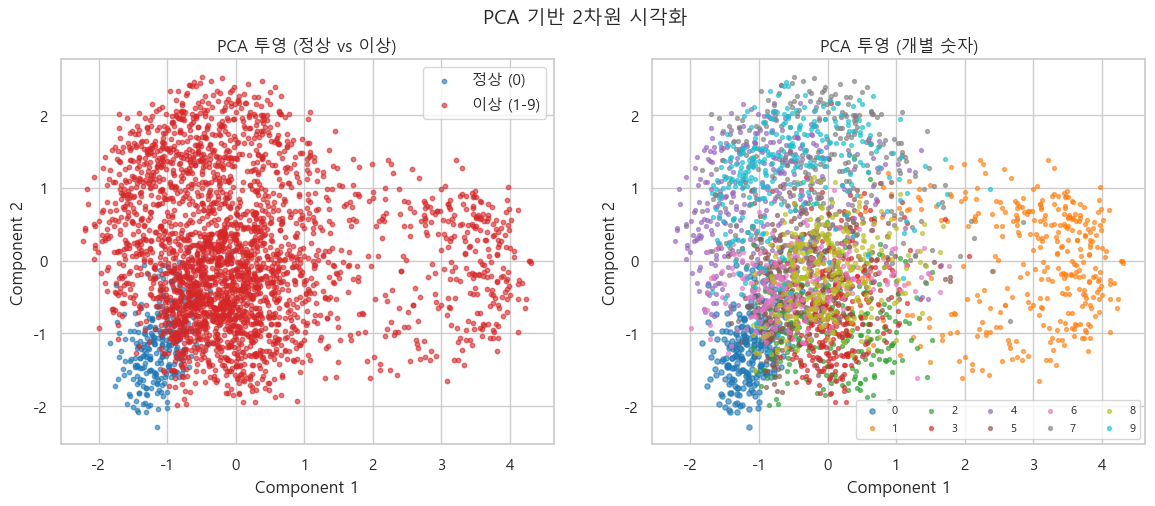

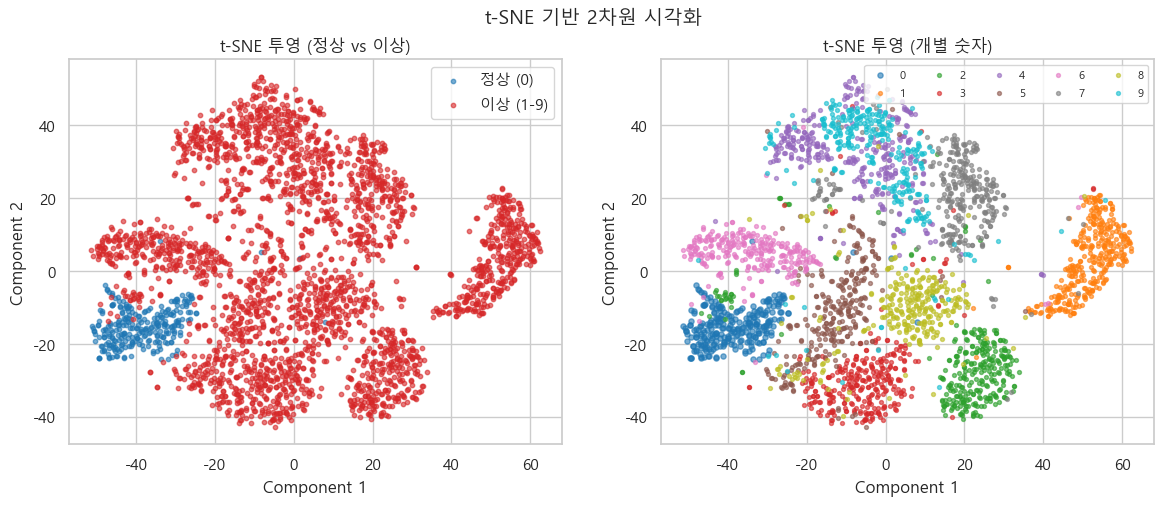

In [6]:

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

def plot_binary_projection(embedding, labels, title, ax=None):
    ax = ax or plt.gca()
    palette = {0: "#1f77b4", 1: "#d62728"}
    for label, color in palette.items():
        mask = labels == label
        ax.scatter(
            embedding[mask, 0],
            embedding[mask, 1],
            s=10,
            alpha=0.6,
            label="정상 (0)" if label == 0 else "이상 (1-9)",
            c=color,
        )
    ax.set_title(title)
    ax.legend(frameon=True)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")


def plot_digit_projection(embedding, digits, title, ax=None):
    ax = ax or plt.gca()
    cmap = plt.cm.get_cmap("tab10")
    for digit in range(10):
        mask = digits == digit
        if mask.sum() == 0:
            continue
        ax.scatter(
            embedding[mask, 0],
            embedding[mask, 1],
            s=8 if digit != 0 else 14,
            alpha=0.6,
            label=f"{digit}",
            c=cmap(digit),
        )
    ax.set_title(title)
    ax.legend(ncol=5, fontsize=8, frameon=True)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")


fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_binary_projection(pca_emb, y_binary, "PCA 투영 (정상 vs 이상)", axes[0])
plot_digit_projection(pca_emb, y_digits, "PCA 투영 (개별 숫자)", axes[1])
fig.suptitle("PCA 기반 2차원 시각화", fontsize=14)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_binary_projection(tsne_emb, y_binary, "t-SNE 투영 (정상 vs 이상)", axes[0])
plot_digit_projection(tsne_emb, y_digits, "t-SNE 투영 (개별 숫자)", axes[1])
fig.suptitle("t-SNE 기반 2차원 시각화", fontsize=14)
plt.show()


# 3.3 변수 특성 및 시각화

데이터는 784차원의 고차원 벡터(28×28 픽셀)로 구성되어 있으며, 모든 변수는 0에서 255 사이의 픽셀 강도 값을 갖습니다. 결측치는 존재하지 않고, 학습 파이프라인에 맞춰 글로벌 대조 정규화(Global Contrast Normalization)가 이미 적용되어 있습니다. 주성분 분석(PCA)과 t-SNE로 2차원 투영을 수행하면 정상 클래스인 숫자 `0`은 하나의 밀집된 클러스터로 모이며, 나머지 숫자(`1`–`9`)는 주변에 여러 개의 작은 클러스터를 형성하면서도 일부(특히 `6`, `9`)는 정상 클러스터와 겹치는 양상을 보여 이상 탐지 난이도가 높음을 확인할 수 있습니다.
